In [1]:
from scipy import stats
import numpy as np

# Approximate Bayesian Computation

Generative models are models which we can generate new data with. Often we do not know an explicit formulation for a generative model (They are black-boxes), especially when they occur in the real-world. Mathematically, generative models are those which capture the distribution of $\mathbb{P}(X,Y)$ where $X,Y$ are observed data and its labels, rather than $\mathbb{P}(Y|X)$ which discriminative models capture.

Approximate Bayesian Computation (ABC) is a family of computational methods, based on Bayesian Statistics, which use simulation to estimate the posterior for parameter values for theorised models, without having to evaluate the likelihood function.

In this notebook I introduce and demonstrate a few ABC algorithms which I have implemented in `ABC.py`.

**Table of Contents**
 * [Motivation](#Motivation-for-ABC)
 * [Modelling](#Modelling)
     * [Models.LinearModels](#Models.LinearModel)
     * [Models.ExponentialModels](#Models.ExponentialModels)
 * [Kernels](#Kernels-$K_\epsilon$)
 * [Summary Statistics](#Summary-Statistics-$s$)
     * [Sufficiency](#Sufficiency)
 * [ABC Algorithms](#ABC-Algorithms)
     * [Components of ABC](#Components-of-ABC)
     * [ABC-Rejection Sampling](#ABC-Rejection-Sampling)
         * [Implementation](#rejection_implementation)
             * [Linear Model](#rejection_linear_model)
             * [Exponential Model](#rejection_exponential_model)
     * [ABC-MCMC](#ABC-MCMC)
         * [Implementation](#mcmc_implementation)
     * [ABC-SMC](#ABC-SMC)
         * [Implementation](#smc_implementation)

## Motivation for ABC
Consider a set of $n$ observations from the model we intend to fit to $Y_{obs}=\{y_{obs,1},\dots,y_{obs,n}\}$ with $y_{obs,i}\in\mathbb{R}^m$ and a simulation $Y=\{y_1,\dots,y_n\}$ with $y_i\in\mathbb{R}^m$ with the theoretical model parameterised by $\theta$.

To fit our theorised model we want to determine the posterior for the parameters $\theta$ given the observed data $Y_{obs}$.

$$ \mathbb{P}(\theta|Y_{obs}) $$

Bayes' Rule gives the following formulation for this posterior

$$ \mathbb{P}(\theta|Y_{obs})=\dfrac{\mathbb{P}(Y_{obs}|\theta)\mathbb{P}(\theta)}{\mathbb{P}(Y_{obs})} $$

As we are only interested the ratio of weight the posterior gives to each possible $\theta$, we can ignore the evidence term $\mathbb{P}(\theta)$ as its only job is to normalise the posterior to be a probability distribution.

We define the prior $\mathbb{P}(\theta)$ for our model, ideally encoding some prior knownledge. Thus, the only task left if to calculate the likelihood $\mathbb{P}(Y_{obs}|\theta)$. For most real world scenarios this calculation is intractable (both mathematically and computationally). ABC provides methods for getting around this.

## Modelling

In [2]:
from Models import LinearModel,ExponentialModel

The program `Models.py` provides a framework for defining generative models.

`Models.Model` is an *interface* which you need to implement for each model in order for my later methods to work. I have implemented some common models 
 * `Models.LinearModel`, $\theta_0+\sum\theta_iX_i$.
 * `Models.ExponentialModel`, $\theta_0\exp\{X\theta_1\}$.

The "generative" nature of these models is realised by making them "time-series" models and ensuring the same set of values are returned each time the exact same object is queried.

### `Models.LinearModel`
Below I implement the linear model `lm` with mathematical formulation
$$ f(X)=1+10X+\varepsilon\text{ where }\varepsilon\sim\mathcal{N}(0,30) $$

I specify that this model is only observed at values $X=\{1,2,\dots,10\}$ (and in that order). This model generates a single observation of dimension 10, $y_1\in\mathbb{R}^{10}$.

In [3]:
# Specify the model
np.random.seed(16111998) # Fix random seed
lm=LinearModel(
    n_params=2,
    params=[1,10],
    n_vars=1,
    n_obs=10,
    x_obs=[[x] for x in range(10)],
    noise=30,
)

# Observe the model (will be the same each time this object is observed)
lm.observe()

[[2.950068147167192],
 [6.582033773389246],
 [19.352977309887507],
 [23.073409099211318],
 [42.002592041406075],
 [46.240787044118285],
 [56.52241872907294],
 [75.75469430652853],
 [89.52725765204846],
 [96.057868970883]]

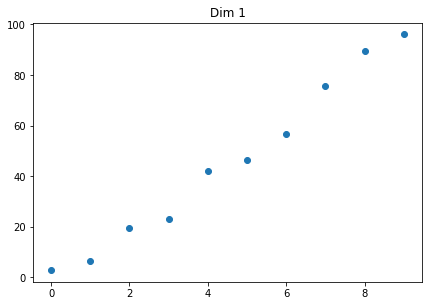

In [4]:
# Plot the observations
lm.plot_obs()

### `Models.ExponentialModel`
Below I implement the exponential model `em` with mathematical formulation
$$ f(X)=2e^{3X/10}+\varepsilon\text{ where }\varepsilon\sim\mathcal{N}(0,1) $$
Again, I specify that this model is only observed at values $X=\{1,2,\dots,10\}$ (and in that order). This model generates a single observation of dimension 10, $y_1\in\mathbb{R}^{10}$.

In [5]:
# Specify the model
np.random.seed(16111998) # Fix random seed
em=ExponentialModel(
    params=[2,.3],
    n_obs=10,
    x_obs=[[x] for x in range(10)],
    noise=1,
)

# Observe the model (will be the same each time this object is observed)
em.observe()

[array([3.3560321]),
 array([2.54325222]),
 array([3.52141497]),
 array([3.01241223]),
 array([5.50316435]),
 array([5.61277964]),
 array([7.23215671]),
 array([11.03425435]),
 array([14.5800335]),
 array([17.80316803])]

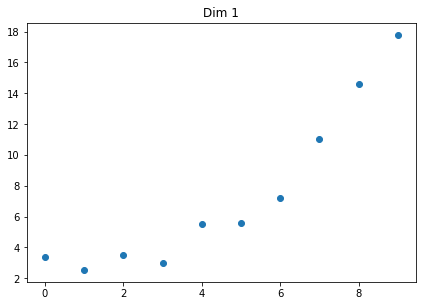

In [6]:
# Plot the observations
em.plot_obs()

## Kernels $K_\epsilon$
Kernels are functions which are used compare data by making it linearly seperable. Kernels are used in ABC to determine how similar simulated data is to observed data.

Most kernels have "bandwidth" parameter $\epsilon$ which specifies how similar data needs to be. A greater bandwidth means data doesn't need to be as similar, this leads to more observations being accepted and quicker computation, but decreased accuracy.

Here are some popular kernels for ABC
 * Uniform Kernel $K_\epsilon(x)=\mathbb{1}\{|x|\leq\epsilon\}$.
 * Epanechnikov Kernel $K_\epsilon(x)=\frac3{4\epsilon}\left(1-\frac{x^2}{\varepsilon^2}\right)\mathbb{1}\{|x|\leq\epsilon\}$.
 * Gaussian Kernel $K_\epsilon(x)=\frac1{\sqrt{2\pi}}\exp\left\{-\frac12x^2\right\}$
 
In ABC $x=\|s-s_{obs}\|\in\mathbb{R}$ where $s$ is the summary statistic value of a sample, $s_{obs}$ is the summary statistic value of the originally observed data and $\|\cdot\|$ is some distance measure (Typically euclidean).
 
These kernels return a weighting which is often interpretted, in ABC, as the probability that we accept a given simulation. In practice we sample from $p\sim\mathcal{U}[0,1]$ and if $p>K_\epsilon(x)$ then we accept the simulation.

## Summary Statistics $s$
A Summary statistic is a projection of high-dimensional data to a lower dimensional space.

$$ s:\mathbb{R}^m\to\mathbb{R}^n\text{ with }n\ll m $$

In ABC several summary statistics are applied to observed and simulated data in order to reduce the total dimensionality of data and thus reduce the computational requirements of each algorithm. The use of summary statistics is often required just to make the algorithms computationally tractable.

Greater reduction in dimensionality leads to more data being lost meaning the posterior produced by ABC is less accurate and less stable. This means the trade-off is between computational efficiency and model accuracy.

In most settings observed and simulated data consist of multiple observations each with multiple dimension meaning that summary statistics in ABC typically have the following signature
$$ s:\mathbb{R}^{n\times m}\to\mathbb{R}^p\text{ with }p\ll n\times m $$
where $n$ is the number of observations, $m$ is the dimension of each observation and $p$ is the dimension of the summary.

Moreover, as ABC uses several summary statistics and each can map to a different dimension we what $\sum p_i\ll n\times m$ where $\{p_1,\dots,p_k\}$ are the dimensions of the summaries produced by $k$ different summary statistics.

**Note**
When using multiple summary statistics more questions arise about which (if any) are more important. 

### Sufficiency
A set of summary statistics $S=\{s_1,\dots,s_k\}$ are said to be "Sufficient" if they carry enough data in order to fully determine the parameters of a model.
$$ \mathbb{P}(X|S(X),\theta)=\mathbb{P}(X|S(X))\text{ where }X\sim f_\theta(\cdot) $$

The *Pitman–Koopman–Darmois Theorem* states that sufficient sets of summary statistics only exist for distributions from the exponential family. As most real world distributions do not come from the exponential family this means we need to consider other qualities.

"Approximate Sufficiency" is a metric for finding sets of summary statistics whcih statisfy some optimality condition to do with sufficiency, and can be applied to any distribution.

## ABC Algorithms

In [7]:
import ABC

# Size plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

### Components of ABC
To perform ABC we typically need/define the following features
 * A set of $n$ observations $Y_{obs}=\{y_{obs,1},\dots,y_{obs,n}\}$ from our generative model with $y_{obs,i}\in\mathbb{R}^m$ for large $m$.
 * A theorised model $f_\theta(\cdot)$ for the generative model, which can be simualted from. (See [Modelling](#Modelling))
 * A prior $\pi_0(\cdot)$ for each parameter of the theorised model.
 * A set of summary statistics $s:\mathbb{R}^m\to\mathbb{R}^k$ mapping each observation $y_i$ to a lower dimension. (See [Summary Statistics](#Summary-Statistics-$s$))
 * A kernel $K_\epsilon(\cdot)$ with bandwith $\epsilon$. (See [Kernels](#Kernels))
 * A distance measure $\|\cdot\|$.

### ABC-Rejection Sampling
The rejection sampling algorithm is the simplist implementation of ABC.

The general premise is to keep randomly initialising and simulating our theorised model until enough "good" simulations have occured. A simulation is deemed "good" if it is sufficiently close to observed data from the true model.

Consider the setup described [above](#Components-of-ABC). Here is an algorithm for ABC-Rejection Sampling
<ol>
  <li>
      Calculate the summary statistic values $s_{obs}$ from the observed data $Y_{obs}$.
      $$ s_{obs}=s(Y_{obs}) $$
  </li>
  <li>
      Until stopping condition is reached
    <ol>
      <li>
          Sample a set of parameters $\tilde\theta_t$ from the priors $\pi_0(\theta)$.
          $$ \tilde\theta_t\sim\pi_0(\theta) $$
      </li>
      <li>
          Initialise the theorised model $f_{\tilde\theta_t}$ with the sampled parameters $\tilde\theta_t$ and simulate data $Y_t$.
        $$ Y_t\sim f_{\tilde\theta_t}(Y) $$
      </li>
      <li>
          Calculate the summary statistic values $s_t$ for the simulate data $Y_t$.
        $$ s_t=s(Y_t) $$
      </li>
      <li>
          Reject this simulation with probability $K_\epsilon(\|s_t-s_{obs}\|)$.
          <br>If the simulation is accepted then record the parameter values $\tilde\theta_t$ and summary statistic $s_t$.
      </li>
    </ol>
  </li>
  <li>
    Return the accepted parameter values
  </li>
</ol>

Different variations on this algorithm have different stopping conditions:
 * *Fixed Number* ("Stop once $N$ simulations have been accepted"). Good as we can define how good a simulation needs to be accepted. Bad as an unknown number of simulations will be performed.
 * *Best Samples* ("Perform $M$ simulations and keep the best $N$"). Good as the algorithm will perform a known number of simulations. Bad as we cannot control how good the accepted simulations will be.

<a id="rejection_implementation"></a>
### Implementation
Here I shall demonstrate my implementation of the ABC-Rejection Sampling algorithm.

But first some details about my implementation:
 * In the *Fixed Number* variation, when using multiple summary statistics at least 60\% (unless otherwise specified) of the simulated summary statistic values need to be accepted by the kernel for the simulation to be accepted.
 * In the *Best Samples* variation, when using multiple summary statistics each simulation is given a weighted equal to the sum of the values calculated by the kernel for each summary statistic. The $N$ simulations with the lowest weights are chosen.

<a id="rejection_linear_model"></a>
**Linear Model**

First I shall use the linear model defined [above](#Models.LinearModel). The true model here is $f(X)=1+10X+\varepsilon$ with $\varepsilon\sim\mathcal{N}(0,30)$ and my theorised model is $f_\theta(X)=\theta_0+\theta_1X$ (I am not going to estimate the variance of the additive noise).

Below I run the algorithm twice:
 * First time stops once 100 simulations have been accepted. Acceptance is determined by using a uniform kernel with bandwith $\epsilon=.7$.
 * Second time runs 1,000 simulations and uses the best 100.

In both cases the returned `fitted_model` uses the mean of the accepted values for each parameter. All simulations are given even weighting in this mean, but this could be extended to give greater weight to simulations which produce summary statistics which are close to $s_{obs}$.

*Priors*

For the priors I am using $\pi_{0}(\theta_0)\sim\mathcal{U}[0,6]$ and $\pi_0(\theta_1)\sim\mathcal{U}[8,14]$. These priors are informative as they do include the true values for each parameter, but the expected value of each prior is not the true value of the parameter.

In [8]:
# Define Priors
lm_priors=[stats.uniform(0,6),stats.uniform(8,6)]

*Summary Statistics*

I have chosen three summary statistics
 * $s_0$ - Value of the first observation.
 * $s_1$ - Value of the last (tenth) observation.
 * $s_2$ - Mean change in value between consecutive observations.

In [9]:
# Define Summary Statistics
start = (lambda ys:[ys[0][0]])
end = (lambda ys:[ys[-1][0]])
mean_grad = (lambda ys:[np.mean([ys[i+1][0]-ys[i][0] for i in range(len(ys)-1)])])
summary_stats=[start,end,mean_grad]

(1,331) 100/100



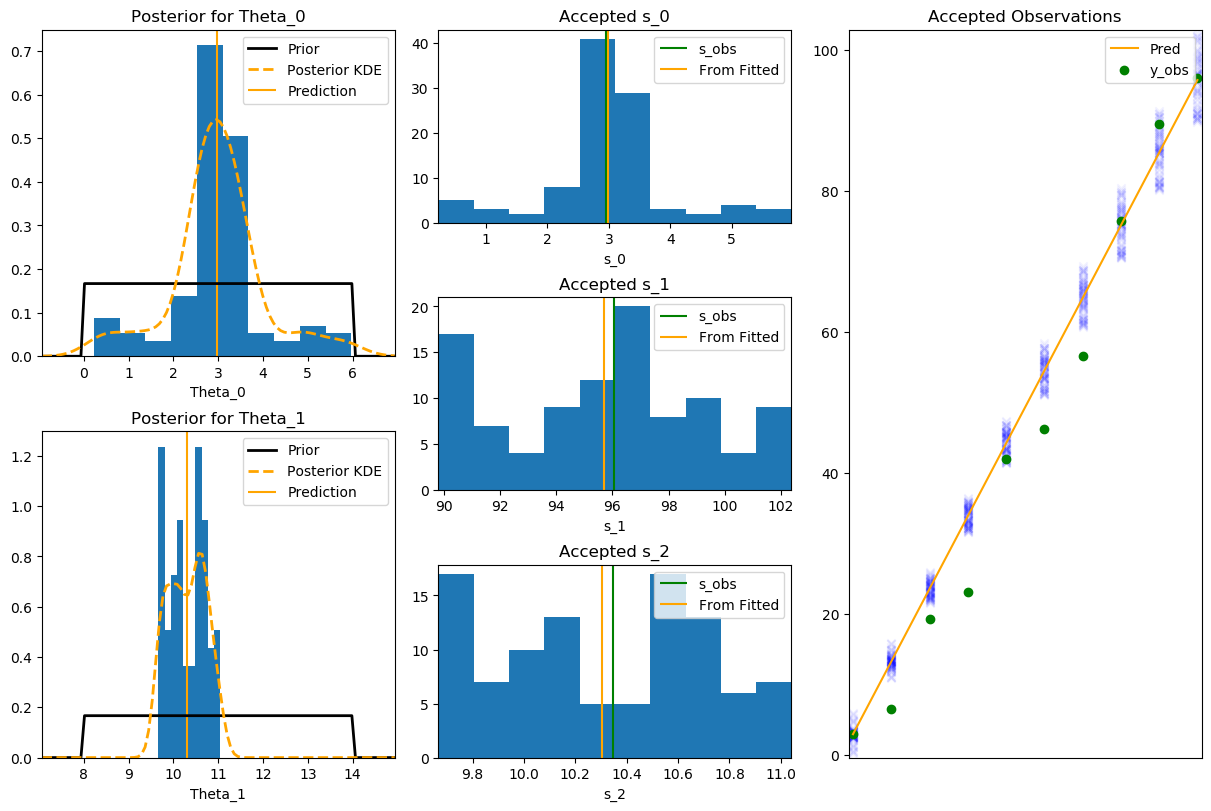

True Model - 1.000+10.000*x0+N(0,30.000)
Fitted Model - 2.983+10.303*x0



In [10]:
# First Run - FIXED NUMBER - Until 100 acceptances
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"fixed_number","sample_size":100,"scaling_factor":.7,"kernel_func":ABC.uniform_kernel}

fitted_model=ABC.abc_rejcection(n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("True Model - {}".format(lm))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

1,331 simulations were required for 100 to be accepted.

The returned fitted model was $\hat{f}(X)=2.983+10.303X$ which shows a good fit for the second coefficient, but not for the first. This is due to noise in the true model meaning that the first data point has value $\sim2.95$. Looking at the plot of the fitted model and accepted simulations (RHS), we can see that despite noise meaning many data points do not lie near their true value, the fitted model is very good.

The histograms for the accepted values of each summary statistic (middle col) show that the values which were accepted were very close to the true values for all summary statistics. This is to be expected due to this variation of the algorithm only accepting observations which are close (although my implementation only required 2/3 of the simulated summary statistic values  to be close to their observed counterparts).

The distributions for each parameter (left col) shows that the posteriors have a significantly different shape to the priors, indicating that significant learning has occurred. Moreover, a significant amount of weight in the posteriors is placed near the true parameter values.

(999/1,000)



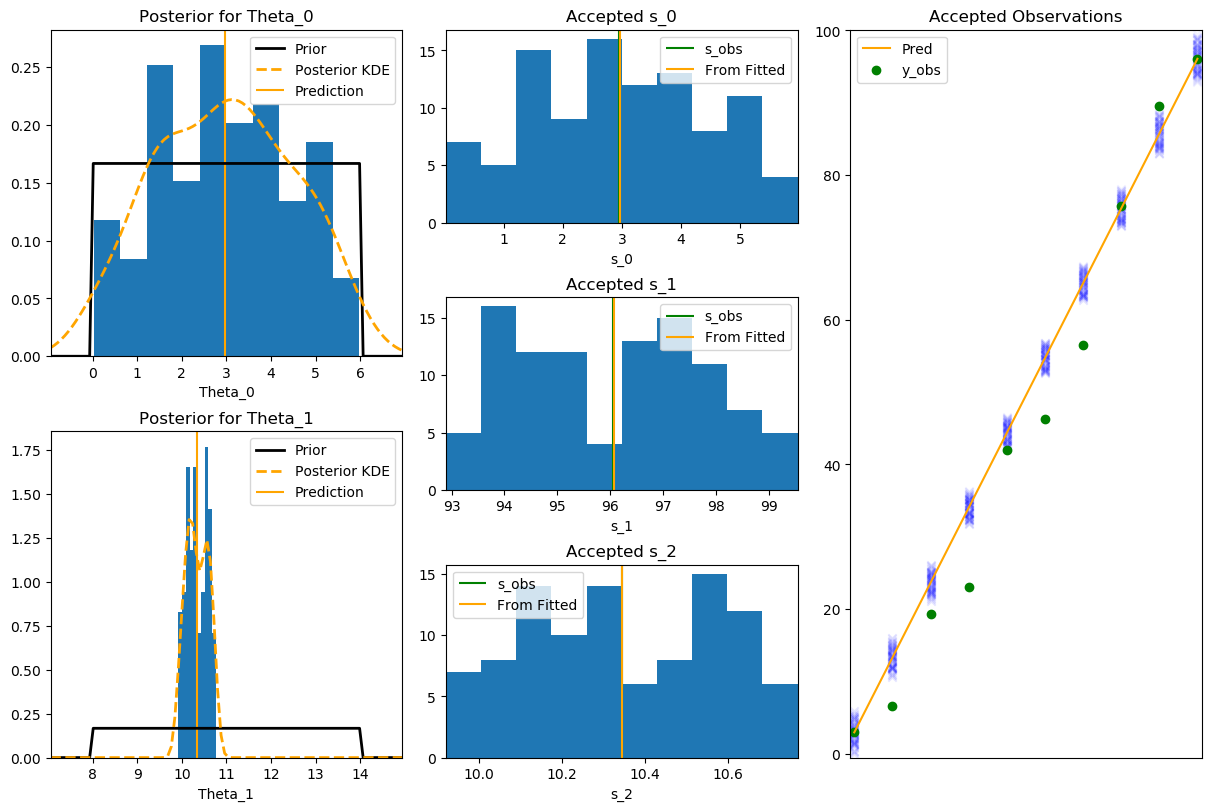

True Model - 1.000+10.000*x0+N(0,30.000)
Fitted Model - 2.963+10.345*x0



In [11]:
# Second Run - BEST SAMPLES - 10,000 simulations keeping best 100
np.random.seed(16111998) # Fix random seed

sampling_details={"sampling_method":"best","num_runs":1000,"sample_size":100}

fitted_model=ABC.abc_rejcection(n_obs=10,y_obs=lm.observe(),fitting_model=lm.copy([1,1]),priors=lm_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("True Model - {}".format(lm))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The returned fitted model was $\hat{f}=2.963+10.345X$. This is very similar to the model returned by the *Fixed Number* variation above.

The analysis of the results here is very similar to that above, likely due to them both running a similiar number of iterations (with the same seed). The only notable difference is that the posterior for the first parameter $\theta_0$ in this variation is not that different from its prior, and the same can be seen in the accepted values of $s_0$. This is likely due to $\theta_0$ being less important to the overall fit of the theorised model than $\theta_1$ (Which is explainable and to be expected). The fact that the fitted model in both variations is almost identical emphasises this.

The fitted value $\hat\theta_0$ is likely only close to the observed value of the first data point as that value is close to the mean of the prior defined for $\theta_0$.

<a id="rejection_exponential_model"></a>
**Exponential Model**

Now I shall use the exponential model defined [above](#Models.ExponentialModel). The true model here is $f(X)=2\exp(3X/10)+\varepsilon$ with $\varepsilon\sim\mathcal{N}(0,1)$ and my theorised model is $f_\theta(X)=\theta_0\exp(\theta_1X)$. (I am not going to estimate the variance of the additive noise).

I only run the *Best Samples* variation of the algorithm, performing 1,000 simulations and accepting the best 100. I do not run both variations as I just wish to demonstrate that ABC-Rejection Sampling works on the slightly more complicated exponential model.

The returned `fitted_model` uses the mean of the accepted values for each parameter.

*Priors*

For the priors I am using $\pi_{0}(\theta_0)\sim\mathcal{U}[0,3]$ and $\pi_0(\theta_1)\sim\mathcal{U}[0,1]$. These priors are informative as they do include the true values for each parameter, but the expected value of each prior is not the true value of the parameter.

In [12]:
# Define Priors
em_priors=[stats.uniform(0,3),stats.uniform(0,1)]

*Summary Statistics*

I have chosen three summary statistics
 * $s_0$ - Value of the first observation.
 * $s_1$ - Value of the last (tenth) observation.
 * $s_2$ - Mean $\log$-change in value between consecutive observations.

In [13]:
# Define Summary Statistics
start = (lambda ys:[ys[0][0]])
end = (lambda ys:[ys[-1][0]])
mean_log_grad = (lambda ys:[np.mean([np.log(max(1,ys[i+1][0]-ys[i][0])) for i in range(len(ys)-1)])])
summary_stats=[start,end,mean_log_grad]

(999/1,000)



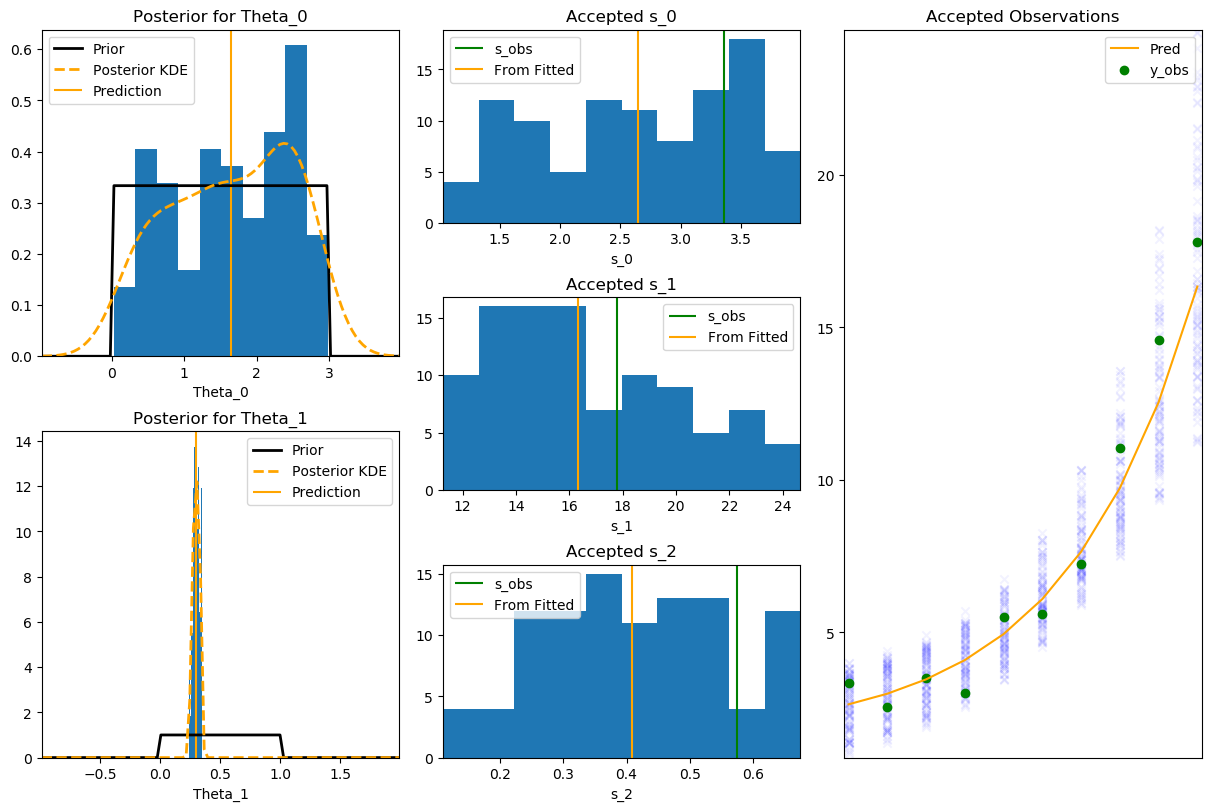

True Model - 2.000*e^(0.300*x0)+N(0,1.000)
Fitted Model - 1.645*e^(0.299*x0)



In [14]:
# Second Run - BEST SAMPLES - 10,000 simulations keeping best 100
np.random.seed(16111998) # Fix random seed
sampling_details={"sampling_method":"best","num_runs":1000,"sample_size":100}

fitted_model=ABC.abc_rejcection(n_obs=10,y_obs=em.observe(),fitting_model=em.copy([1,1]),priors=em_priors,sampling_details=sampling_details,summary_stats=summary_stats)
print("True Model - {}".format(em))
print("Fitted Model - {}\n".format(fitted_model))

*Comments*

The returned fitted model is $\hat{f}(X)=1.645\exp(0.299X)$. This again shows a very good fit for $\theta_1$ but not for $\theta_0$. The posterior for $\theta_0$ is practically unchanged from its prior. Moreover, the fitted value $\hat\theta_0$ likely is just the mean of the prior assigned to $\theta_0$ (Indicating no learning has occured for $\theta_0$). While, the posterior for $\theta_1$ places almost all its weight on the true value.

This shows us that $\theta_1$ is a significantly more important parameter when fitting an exponential model than $\theta_0$. This can be seen by noting (in the right-hand plot) how well the fitted model fits the observed data.

### ABC-MCMC

<a id="mcmc_implementation"></a>
### Implementation

### ABC-SMC

<a id="smc_implementation"></a>
### Implementation

# TODO
 * Priors
 * Sufficient statistics
     * Approximate Suffiency
 * ABC-Importance Sampling